# Spark Setup and Configs

In [1]:
# ============================================
# High-memory local Spark session (RUN FIRST)
# ============================================
from pyspark.sql import SparkSession

try:
    spark.stop()
except Exception:
    pass

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "8g")            # bump as your RAM allows (12g/16g if available)
    .config("spark.executor.memory", "8g")
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.kryoserializer.buffer.max", "1024m")
    .config("spark.sql.shuffle.partitions", "64")
    .config("spark.default.parallelism", "64")
    .getOrCreate()
)

print("Spark session ready. Version:", spark.version)

# ===== Spark session guards =====
def ensure_spark():
    """Raise a clear error if SparkSession 'spark' is missing or inactive."""
    try:
        _ = spark.range(1).count()
    except NameError as e:
        raise RuntimeError("SparkSession 'spark' is not defined. Run the High-memory Spark cell at the top.") from e
    except Exception as e:
        raise RuntimeError("SparkSession is not active. Rerun the High-memory Spark cell at the top.") from e

def ensure_df_session(df, name="DataFrame"):
    """Ensure a given DataFrame belongs to the current active SparkSession."""
    ensure_spark()
    try:
        same = df.sql_ctx.sparkSession._jsparkSession == spark._jsparkSession
    except Exception as e:
        raise RuntimeError(f"Could not verify the SparkSession for {name}.") from e
    if not same:
        raise RuntimeError(f"{name} was created under a different SparkSession. "
                           "Recreate it after running the High-memory Spark cell.")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/23 19:15:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session ready. Version: 4.0.1


In [2]:

# ===== Robust Spark action helpers (AQE/broadcast disabled for action; backward-compatible) =====
from contextlib import contextmanager
from pyspark import StorageLevel

@contextmanager
def _tmp_conf(key, value):
    prev = spark.conf.get(key, None)
    spark.conf.set(key, value)
    try:
        yield
    finally:
        if prev is None:
            spark.conf.unset(key)
        else:
            spark.conf.set(key, prev)

@contextmanager
def _stable_action_mode():
    """Temporarily turn off AQE and broadcast joins for stability during an action."""
    with _tmp_conf("spark.sql.adaptive.enabled", "false"):
        with _tmp_conf("spark.sql.autoBroadcastJoinThreshold", "-1"):
            yield

def safe_count(df, checkpoint=False, **kwargs):
    """
    Materialize count with stability tweaks:
      * persist MEMORY_AND_DISK to cut lineage
      * disable AQE and broadcast joins during the action
    The 'checkpoint' kwarg is accepted for backward compatibility but ignored.
    """
    # Ensure Spark is alive
    _ = spark.range(1).count()
    dfp = df.persist(StorageLevel.MEMORY_AND_DISK)
    try:
        with _stable_action_mode():
            return dfp.count()
    finally:
        try:
            dfp.unpersist()
        except Exception:
            pass


# Feature-Aggregated Data Quality Assessment & ML Pipeline (Spark) — Structured Notebook

This notebook was generated from your uploaded script and organized into clear sections.
It covers:
- Environment setup (Java & PySpark)
- Zero% data-quality analysis across aggregation levels
- A target/feature mapping–driven ML baseline
- A fully time-aware **Next-Quarter Forecasting** pipeline with lags/rolling means

---


## Table of Contents

1. [Overview & Run Log](#overview)
2. [Environment Setup](#setup)
3. [Optimized Zero% Analysis](#zero)
4. [ML Modeling (Target/Feature Mapping)](#ml)
5. [Next-Quarter Forecasting](#nextq)


## <a id="overview"></a> 1) Overview & Run Log

<details>
<summary>Show original summary / run log</summary>

```
✅ Dataset loaded: 547,336 rows, 295 columns
📅 Years detected in dataset: [2017, 2018, 2019, 2020, 2021]
✅ Retained only 'Total' sector rows (109,571/547,336)
⚠️ Warning: 873 duplicate subdistrict-date groups remain after filtering!
✅ Data cached after cleaning. Rows retained: 109,571
✅ Identified 293 numeric columns for Zero% analysis
➡️ Raw (Subdistrict–Month): 109,571 grouped rows (5 years covered)
➡️ Subdistrict–Quarter: 38,610 grouped rows (5 years covered)
➡️ District–Month: 18,006 grouped rows (5 years covered)

✅ Outputs saved:
   • Zero% summary → /content/hmis_zero_pct_summary_v4
   • Row & Year summary → /content/hmis_rows_summary_v4

📊 === Row & Year Coverage by Aggregation ===
+-----------------------+--------+---------+
|aggregation_level      |num_rows|num_years|
+-----------------------+--------+---------+
|Raw (Subdistrict–Month)|109571  |5        |
|Subdistrict–Quarter    |38610   |5        |
|District–Month         |18006   |5        |
+-----------------------+--------+---------+


📈 === Sample Zero% Summary (first 10 columns, sorted) ===
+--------------------------------+--------------+-----------------------+-------------------+
|column_name                     |District–Month|Raw (Subdistrict–Month)|Subdistrict–Quarter|
+--------------------------------+--------------+-----------------------+-------------------+
|month                           |0.0           |0.0                    |0.0                |
|quarter                         |0.0           |0.0                    |0.0                |
|state_code                      |0.0           |0.0                    |0.0                |
|district_code                   |0.0           |0.0                    |0.0                |
|id                              |0.0           |0.0                    |0.0                |
|subdistrict_code                |0.0           |0.0                    |0.0                |
|year                            |0.0           |0.0                    |0.0                |
|allopathic_outpatient_attendance|0.44          |1.93                   |1.58               |
|child_immunisation_pentavalent_3|0.42          |2.41                   |1.69               |
|child_immunisation_pentavalent_2|0.43          |2.39                   |1.71               |
+--------------------------------+--------------+-----------------------+-------------------+
only showing top 10 rows

✅ ML aggregation ready: 38,610 subdistrict–quarter records

🎯 Training for target: institutional_deliveries_including_csections (23 features)
   ✅ LinearRegression → R² = 0.984

🎯 Training for target: still_birth (18 features)
   ✅ LinearRegression - R² = 0.793

🎯 Training for target: number_of_newborns_having_weight_less_than_25_kg (12 features)
   ✅ LinearRegression - R² = 0.821

🎯 Training for target: child_9_11_months_fully_immunized_female (16 features)
   ✅ LinearRegression → R² = 0.985

🎯 Training for target: allopathic_outpatient_attendance (15 features)
   ✅ LinearRegression → R² = 0.901

✅ Model performance summary saved → /content/hmis_ml_results_v2
+------------------------------------------------+----------------+--------+
|Target                                          |Model           |R2_Score|
+------------------------------------------------+----------------+--------+
|institutional_deliveries_including_csections    |LinearRegression|0.984   |
|still_birth                                     |LinearRegression|0.793   |
|number_of_newborns_having_weight_less_than_25_kg|LinearRegression|0.821   |
|child_9_11_months_fully_immunized_female        |LinearRegression|0.985   |
|allopathic_outpatient_attendance                |LinearRegression|0.901   |
+------------------------------------------------+----------------+--------+

✅ Subdistricts with >=8 quarters retained; rows now: 29,435
🧩 Creating lag and rolling mean features for 49 columns...
✅ Created lag and rolling mean features safely → 545 columns, 29,435 rows.
⏳ Dynamic split_index at 80th percentile = 20204

🔎 Preparing target: institutional_deliveries_including_csections
  Using 69 features after adding engineered variants.
    ✅ LinearRegression | RMSE=2070.935 MAE=812.101 MAPE=291.64% R2=0.625
    ✅ RandomForest | RMSE=2203.289 MAE=957.682 MAPE=228.02% R2=0.575
    ✅ GBT | RMSE=950.083 MAE=495.926 MAPE=190.73% R2=0.921

🔎 Preparing target: still_birth
  Using 54 features after adding engineered variants.
    ✅ LinearRegression | RMSE=45.756 MAE=17.080 MAPE=177.30% R2=0.575
    ✅ RandomForest | RMSE=47.838 MAE=17.660 MAPE=171.54% R2=0.536
    ✅ GBT | RMSE=25.236 MAE=10.575 MAPE=131.20% R2=0.871

🔎 Preparing target: number_of_newborns_having_weight_less_than_25_kg
  Using 36 features after adding engineered variants.
    ✅ LinearRegression | RMSE=352.280 MAE=132.068 MAPE=410.23% R2=0.406
    ✅ RandomForest | RMSE=378.862 MAE=158.020 MAPE=324.78% R2=0.313
    ✅ GBT | RMSE=238.281 MAE=100.079 MAPE=281.25% R2=0.728

🔎 Preparing target: child_9_11_months_fully_immunized_female
  Using 48 features after adding engineered variants.
    ✅ LinearRegression | RMSE=1155.555 MAE=470.097 MAPE=118.70% R2=0.628
    ✅ RandomForest | RMSE=1443.124 MAE=591.478 MAPE=117.57% R2=0.419
    ✅ GBT | RMSE=1031.990 MAE=422.323 MAPE=92.16% R2=0.703

🔎 Preparing target: allopathic_outpatient_attendance
  Using 45 features after adding engineered variants.
    ✅ LinearRegression | RMSE=145296.740 MAE=54110.820 MAPE=151.73% R2=0.797
    ✅ RandomForest | RMSE=149384.216 MAE=53151.406 MAPE=225.26% R2=0.786
```
</details>


## <a id="setup"></a> 2) Environment Setup

In [3]:
ensure_spark()
# ====================== Setup =================================
# !apt-get install openjdk-11-jdk -qq > /dev/null
# !pip install pyspark -q

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

# Temurin 17
import os
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/temurin-17.jdk/Contents/Home"
os.environ["PATH"] = os.path.join(os.environ["JAVA_HOME"], "bin") + os.pathsep + os.environ.get("PATH","")

# Verify Java is available to this kernel
import subprocess
subprocess.call("java -version", shell=True)

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.version

PROJECT_HOME = os.getcwd()
OUTPUT_DIR = f"{PROJECT_HOME}/output_dir/"

openjdk version "17.0.17" 2025-10-21                                            
OpenJDK Runtime Environment Temurin-17.0.17+10 (build 17.0.17+10)
OpenJDK 64-Bit Server VM Temurin-17.0.17+10 (build 17.0.17+10, mixed mode, sharing)


## <a id="zero"></a> 3) Optimized Zero% Analysis

In [4]:
# ============================================================
# Optimized HMIS Zero% Analysis (with Year Coverage Summary)
# ------------------------------------------------------------
# Handles inconsistent date formats (2017–2020 etc.)
# Ensures all years retained and reports distinct year counts
# Scales up to 10M+ rows efficiently
# ============================================================

# ------------------------------------------------------------
# Initialize Spark
# ------------------------------------------------------------
ensure_spark()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark import StorageLevel

try:
    spark.stop()
except:
    pass

spark = SparkSession.builder.getOrCreate()

spark = (
    SparkSession.builder
    # --- memory / serialization / shuffles ---
    .config("spark.driver.memory", "8g")            # bump as high as your RAM allows (e.g., 12g/16g)
    .config("spark.executor.memory", "8g")          # local-mode uses driver=executor; harmless to set
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.kryoserializer.buffer.max", "1024m")
    .config("spark.sql.shuffle.partitions", "64")   # fewer/larger partitions to reduce overhead
    .config("spark.default.parallelism", "64")
    .getOrCreate()
)
print("Spark session ready. Version:", spark.version)

# ------------------------------------------------------------
# Load dataset
# ------------------------------------------------------------
# file_path = "/content/major-health-indicators-subdistrict-level.csv"
file_path = PROJECT_HOME+"/data/major-health-indicators-subdistrict-level.csv"

df = (
    spark.read
        .option("header", True)
        .option("inferSchema", True)
        .option("multiLine", True)
        .option("quote", '"')              # handle quoted multiline fields
        .option("escape", '"')             # escape quote chars inside fields
        .option("mode", "PERMISSIVE")      # don't drop rows with parse errors
        .option("ignoreLeadingWhiteSpace", True)
        .option("ignoreTrailingWhiteSpace", True)
        .option("wholeFile", True)         # ensures multiline quoted sections are read as one logical file
        .csv(file_path)
)

print(f"Dataset loaded: {df.count():,} rows, {len(df.columns)} columns")

# --------------------------------------------------------------
# Clean dates
# --------------------------------------------------------------
df = df.withColumn(
    "date",
    F.coalesce(
        F.to_date("date", "yyyy-MM-dd"),
        F.to_date("date", "dd-MM-yyyy"),
        F.to_date("date", "MM/dd/yyyy"),
        F.to_date("date", "yyyy/MM/dd")
    )
)
df = df.filter(F.col("date").isNotNull())

# --------------------------------------------------------------
# Derive year, month, quarter, year_month, year_quarter
# --------------------------------------------------------------
df = (
    df.withColumn("year", F.year("date"))
      .withColumn("month", F.month("date"))
      .withColumn("quarter", F.quarter("date"))
      .withColumn("year_month", F.date_format("date", "yyyy-MM"))
      .withColumn("year_quarter", F.concat_ws("-", F.col("year"), F.col("quarter")))
)

years_detected = [r["year"] for r in df.select("year").distinct().orderBy("year").collect()]
print(f"Years detected in dataset: {years_detected}")

# --------------------------------------------------------------
# Retain only 'Total' rows per subdistrict/date
# --------------------------------------------------------------
if "sector" in df.columns:
    before_count = df.count()
    df = df.withColumn("sector_clean", F.trim(F.lower(F.col("sector"))))
    df = df.filter(F.col("sector_clean") == "total").drop("sector_clean")
    after_count = df.count()
    print(f"Retained only 'Total' sector rows ({after_count:,}/{before_count:,})")

# Verify duplicates
dup_check = (
    df.groupBy("state_name", "district_name", "subdistrict_name", "date")
      .count()
      .filter(F.col("count") > 1)
)
dup_count = dup_check.count()
if dup_count > 0:
    print(f"Warning: {dup_count:,} duplicate subdistrict-date groups remain after filtering!")
else:
    print("Each subdistrict-date now uniquely represented (Total sector only).")

# --------------------------------------------------------------
# Drop rows with null keys
# --------------------------------------------------------------
for key in ["state_name", "district_name", "subdistrict_name"]:
    if key in df.columns:
        df = df.filter(F.col(key).isNotNull())

df = df.persist(StorageLevel.MEMORY_AND_DISK)
print(f"Data cached after cleaning. Rows retained: {df.count():,}")

# --------------------------------------------------------------
# Identify numeric columns
# --------------------------------------------------------------
numeric_cols = [
    f.name for f in df.schema.fields
    if f.dataType.simpleString() in ["double", "int", "bigint"]
]
print(f"Identified {len(numeric_cols)} numeric columns for Zero% analysis")

# --------------------------------------------------------------
# Zero% calculation helper
# --------------------------------------------------------------
def compute_zero_pct(df_in, group_cols, level_name, batch_size=30):
    if group_cols:
        df_grouped = df_in.groupBy(*group_cols).agg(
            *[F.sum(F.col(c)).alias(c) for c in numeric_cols]
        )
    else:
        df_grouped = df_in

    df_grouped.cache()
    total_rows = df_grouped.count()
    distinct_years = (
        df_in.select("year").distinct().count()
        if "year" in df_in.columns else 0
    )

    print(f"{level_name}: {total_rows:,} grouped rows ({distinct_years} years covered)")

    zero_data = []
    for i in range(0, len(numeric_cols), batch_size):
        batch = numeric_cols[i:i + batch_size]
        exprs = [
            (F.sum(F.when(F.col(c) == 0, 1).otherwise(0)) / F.lit(total_rows) * 100).alias(c)
            for c in batch
        ]
        row = df_grouped.agg(*exprs).first()
        for c in batch:
            zero_data.append((c, float(row[c]), level_name))

    df_grouped.unpersist()
    return zero_data, total_rows, distinct_years

# --------------------------------------------------------------
# Aggregation levels
# --------------------------------------------------------------
agg_levels = {
    "Raw (Subdistrict-Month)": [],
    "Subdistrict-Quarter": ["state_name", "district_name", "subdistrict_name", "year_quarter"],
    "District-Month": ["state_name", "district_name", "year_month"]
}

if "facility_id" in df.columns:
    agg_levels["Facility-Month"] = ["state_name", "district_name", "facility_id", "year_month"]

# --------------------------------------------------------------
# Run Zero% analysis
# --------------------------------------------------------------
all_zero_data = []
rows_summary = []

for level, group_cols in agg_levels.items():
    try:
        level_data, total_rows, distinct_years = compute_zero_pct(df, group_cols, level)
        all_zero_data.extend(level_data)
        rows_summary.append((level, total_rows, distinct_years))
    except Exception as e:
        print(f"Skipped {level} due to: {e}")

# --------------------------------------------------------------
# Convert results & sort
# --------------------------------------------------------------
zero_df = spark.createDataFrame(all_zero_data, ["column_name", "zero_pct", "level"])
rows_df = spark.createDataFrame(rows_summary, ["aggregation_level", "num_rows", "num_years"])

zero_pivot = (
    zero_df.groupBy("column_name")
           .pivot("level")
           .agg(F.round(F.first("zero_pct"), 2))
           .orderBy(F.col("`Subdistrict-Quarter`").asc_nulls_last())  # sort ascending by Subdistrict–Quarter %
)

# --------------------------------------------------------------
# Save outputs
# --------------------------------------------------------------
# zero_output_path = "/content/hmis_zero_pct_summary_v4"
# rows_output_path = "/content/hmis_rows_summary_v4"
zero_output_path = f"{OUTPUT_DIR}/hmis_zero_pct_summary"
rows_output_path = f"{OUTPUT_DIR}/hmis_rows_summary"

zero_pivot.coalesce(1).write.mode("overwrite").option("header", True).csv(zero_output_path)
rows_df.coalesce(1).write.mode("overwrite").option("header", True).csv(rows_output_path)

print("\nOutputs saved:")
print(f"Zero% summary - {zero_output_path}")
print(f"Row & Year summary - {rows_output_path}")

# --------------------------------------------------------------
# Display summaries
# --------------------------------------------------------------
print("\n === Row & Year Coverage by Aggregation ===")
rows_df.show(truncate=False)

print("\n === Sample Zero% Summary (first 10 columns, sorted) ===")
zero_pivot.show(10, truncate=False)

Spark session ready. Version: 4.0.1


Dataset loaded: 547,336 rows, 295 columns


Years detected in dataset: [2017, 2018, 2019, 2020, 2021]


Retained only 'Total' sector rows (109,571/547,336)


25/11/23 19:16:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


25/11/23 19:16:13 WARN CacheManager: Asked to cache already cached data.        


Data cached after cleaning. Rows retained: 109,571
Identified 293 numeric columns for Zero% analysis
Raw (Subdistrict-Month): 109,571 grouped rows (5 years covered)


Subdistrict-Quarter: 38,610 grouped rows (5 years covered)


District-Month: 18,006 grouped rows (5 years covered)



Outputs saved:
Zero% summary - /Users/nanmr/WorkSpace/IISC_DataScienceAndBusinessAnalytics/DES_DA231o/Project/Delivery_Bundles/V1_Running_InProg/output_dir//hmis_zero_pct_summary
Row & Year summary - /Users/nanmr/WorkSpace/IISC_DataScienceAndBusinessAnalytics/DES_DA231o/Project/Delivery_Bundles/V1_Running_InProg/output_dir//hmis_rows_summary

 === Row & Year Coverage by Aggregation ===
+-----------------------+--------+---------+
|aggregation_level      |num_rows|num_years|
+-----------------------+--------+---------+
|Raw (Subdistrict-Month)|109571  |5        |
|Subdistrict-Quarter    |38610   |5        |
|District-Month         |18006   |5        |
+-----------------------+--------+---------+


 === Sample Zero% Summary (first 10 columns, sorted) ===
+--------------------------------+--------------+-----------------------+-------------------+
|column_name                     |District-Month|Raw (Subdistrict-Month)|Subdistrict-Quarter|
+--------------------------------+--------------

## <a id="ml"></a> 4) ML Modeling (Target/Feature Mapping)

In [5]:

ensure_spark()

# --- Ensure ml_df exists and belongs to current session; build if missing ---
def _exists(name: str) -> bool:
    try:
        eval(name)
        return True
    except NameError:
        return False

if not _exists("ml_df"):
    # We need base 'df' and 'numeric_cols' to construct ml_df
    if not _exists("df") or not _exists("numeric_cols"):
        raise RuntimeError("Base DataFrame `df` and list `numeric_cols` must be defined before ML Modeling.")
    from pyspark.sql import functions as F
    ml_df = (
        df.groupBy("state_name", "district_name", "subdistrict_name", "year_quarter")
          .agg(*[F.sum(F.col(c)).alias(c) for c in numeric_cols])
    )
    ml_df.cache()
    print(f"Built ml_df: {ml_df.count():,} subdistrict-quarter rows")
else:
    ensure_df_session(ml_df, name="ml_df")

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# ------------------------------------------------------------
# Use provided mapping of targets and features
# ------------------------------------------------------------
target_feature_map = {
    "institutional_deliveries_including_csections": [
        "total_number_of_pregnant_women_registered_for_anc",
        "from_total_anc_registered_1st_trimester_in_12_week",
        "number_of_pw_given_180_iron_folic_acid_ifa_tablets",
        "number_of_pw_received_4_or_more_anc_check_ups",
        "number_of_pw_given_360_calcium_tablets",
        "number_of_pw_giventt1",
        "number_of_pw_giventt2",
        "number_of_pw_giventt_booster",
        "number_of_pregnant_women_screened_for_hiv",
        "number_of_pregnant_women_tested_for_syphilis",
        "pw_given_one_albendazole_tab_after_1st_trimester",
        "newborns_breast_fed_within_1_hour_of_birth",
        "number_of_newborns_weighed_at_birth",
        "newborns_6_hbnc_visits_institutional_delivery",
        "immunisation_sessions_planned",
        "immunisation_sessions_held",
        "immunisation_sessions_where_ashas_were_present",
        "anganwadi_centres_uphcs_conducted_vhnds_uhnds",
        "allopathic_outpatient_attendance",
        "ayush_outpatient_attendance",
        "outpatient_dental",
        "outpatient_hypertension",
        "outpatient_diabetes"
    ],

    "still_birth": [
        "total_number_of_pregnant_women_registered_for_anc",
        "number_of_pw_received_4_or_more_anc_check_ups",
        "number_of_pw_given_180_iron_folic_acid_ifa_tablets",
        "number_of_pw_given_360_calcium_tablets",
        "mothers_full_course_of_180_ifa_tab_after_delivery",
        "mothers_prvd_360_calcium_tablets_after_delivery",
        "pw_given_one_albendazole_tab_after_1st_trimester",
        "institutional_deliveries_including_csections",
        "insttl_deliveries_women_discharged_48_hours",
        "newborns_breast_fed_within_1_hour_of_birth",
        "number_of_newborns_weighed_at_birth",
        "number_of_newborns_having_weight_less_than_25_kg",
        "child_immunisation_bcg",
        "child_immunisation_opv_0_birth_dose",
        "child_immune_polio_vaccine_1_ipv_1",
        "number_of_pregnant_women_screened_for_hiv",
        "number_of_pregnant_women_tested_for_syphilis",
        "number_of_hb_tests_conducted"
    ],

    "number_of_newborns_having_weight_less_than_25_kg": [
        "total_number_of_pregnant_women_registered_for_anc",
        "number_of_pw_given_180_iron_folic_acid_ifa_tablets",
        "number_of_pw_given_360_calcium_tablets",
        "number_of_pw_received_4_or_more_anc_check_ups",
        "pw_given_one_albendazole_tab_after_1st_trimester",
        "institutional_deliveries_including_csections",
        "newborns_breast_fed_within_1_hour_of_birth",
        "number_of_newborns_weighed_at_birth",
        "insttl_deliveries_women_discharged_48_hours",
        "child_immunisation_bcg",
        "child_immunisation_opv_0_birth_dose",
        "child_immune_9_11_months_measles_rubella_1st_dose"
    ],

    "child_9_11_months_fully_immunized_female": [
        "child_immunisation_pentavalent_1",
        "child_immunisation_pentavalent_2",
        "child_immunisation_pentavalent_3",
        "child_immunisation_opv1",
        "child_immunisation_opv2",
        "child_immunisation_opv3",
        "child_immunisation_bcg",
        "child_immune_polio_vaccine_1_ipv_1",
        "child_immune_polio_vaccine_2_ipv_2",
        "immunisation_sessions_planned",
        "immunisation_sessions_held",
        "immunisation_sessions_where_ashas_were_present",
        "total_number_of_pregnant_women_registered_for_anc",
        "number_of_pw_received_4_or_more_anc_check_ups",
        "mothers_full_course_of_180_ifa_tab_after_delivery",
        "mothers_prvd_360_calcium_tablets_after_delivery"
    ],

    "allopathic_outpatient_attendance": [
        "immunisation_sessions_planned",
        "immunisation_sessions_held",
        "inpatient_head_count_at_midnight",
        "inpatient_male_adults",
        "inpatient_female_adults",
        "number_of_lab_tests_done",
        "outpatient_diabetes",
        "outpatient_hypertension",
        "outpatient_ophthalmic_related",
        "operation_minor_no_or_local_anaesthesia",
        "emergency_trauma_accident_injury_poisoning_etc",
        "patients_registered_at_emergency_department",
        "anganwadi_centres_uphcs_conducted_vhnds_uhnds",
        "number_of_hb_tests_conducted",
        "total_blood_smears_examined_for_malaria"
    ]
}

# ------------------------------------------------------------
# Aggregate data to Subdistrict–Quarter level for modeling
# ------------------------------------------------------------
ml_df = (
    df.groupBy("state_name", "district_name", "subdistrict_name", "year_quarter")
      .agg(*[F.sum(F.col(c)).alias(c) for c in numeric_cols])
)
ml_df.cache()
print(f"ML aggregation ready: {ml_df.count():,} subdistrict-quarter records")

# ------------------------------------------------------------
# Train models for each target
# ------------------------------------------------------------
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
results = []

for target, feature_cols in target_feature_map.items():
    feature_cols = [c for c in feature_cols if c in ml_df.columns]
    if target not in ml_df.columns or len(feature_cols) < 3:
        print(f"Skipping {target}: insufficient features ({len(feature_cols)} found).")
        continue

    print(f"\nTraining for target: {target} ({len(feature_cols)} features)")

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    data = ml_df.select(*feature_cols, F.col(target).alias("label")).na.fill(0)
    assembled = assembler.transform(data).select("features", "label")
    train_df, test_df = assembled.randomSplit([0.8, 0.2], seed=42)

    models = {
        "LinearRegression": LinearRegression(featuresCol="features", labelCol="label"),
        "RandomForest": RandomForestRegressor(featuresCol="features", labelCol="label", maxDepth=8, numTrees=40),
        "GBTRegressor": GBTRegressor(featuresCol="features", labelCol="label", maxIter=50)
    }

    for model_name, model in models.items():
        try:
            pipeline = Pipeline(stages=[model])
            trained = pipeline.fit(train_df)
            predictions = trained.transform(test_df)
            r2 = evaluator.evaluate(predictions)
            results.append((target, model_name, round(r2, 3)))
            print(f"    {model_name} - R² = {r2:.3f}")
        except Exception as e:
            print(f"    {model_name} failed for {target}: {e}")

# ------------------------------------------------------------
# Save model performance summary
# ------------------------------------------------------------
results_df = spark.createDataFrame(results, ["Target", "Model", "R2_Score"])
results_path = f"{OUTPUT_DIR}/hmis_ml_results"
results_df.coalesce(1).write.mode("overwrite").option("header", True).csv(results_path)

print(f"\nModel performance summary saved - {results_path}")
results_df.show(truncate=False)

Built ml_df: 38,610 subdistrict-quarter rows


25/11/23 19:17:02 WARN CacheManager: Asked to cache already cached data.


ML aggregation ready: 38,610 subdistrict-quarter records

Training for target: institutional_deliveries_including_csections (23 features)


25/11/23 19:17:02 WARN Instrumentation: [3842811c] regParam is zero, which might cause numerical instability and overfitting.
25/11/23 19:17:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/23 19:17:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


    LinearRegression - R² = 0.977


25/11/23 19:17:06 WARN DAGScheduler: Broadcasting large task binary with size 1160.2 KiB
25/11/23 19:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1553.4 KiB
25/11/23 19:17:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


    RandomForest - R² = 0.844


25/11/23 19:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
25/11/23 19:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1000.9 KiB
25/11/23 19:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1002.1 KiB
25/11/23 19:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB
25/11/23 19:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1007.0 KiB
25/11/23 19:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB
25/11/23 19:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
25/11/23 19:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
25/11/23 19:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1011.5 KiB
25/11/23 19:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1014.3 KiB
25/11/23 19:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1014.8 KiB
25/11/23 19:17:34 WAR

    GBTRegressor - R² = 0.864

Training for target: still_birth (18 features)


25/11/23 19:17:43 WARN Instrumentation: [09a5094a] regParam is zero, which might cause numerical instability and overfitting.


    LinearRegression - R² = 0.787


25/11/23 19:17:46 WARN DAGScheduler: Broadcasting large task binary with size 1143.9 KiB
25/11/23 19:17:46 WARN DAGScheduler: Broadcasting large task binary with size 1531.9 KiB
25/11/23 19:17:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


    RandomForest - R² = 0.683


25/11/23 19:18:10 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB
25/11/23 19:18:10 WARN DAGScheduler: Broadcasting large task binary with size 1002.3 KiB
25/11/23 19:18:10 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
25/11/23 19:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
25/11/23 19:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/23 19:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/23 19:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1009.4 KiB
25/11/23 19:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
25/11/23 19:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1012.4 KiB
25/11/23 19:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1013.0 KiB
25/11/23 19:18:12 WARN DAGScheduler: Broadcasting large task binary with size 1014.2 KiB
25/11/23 19:18:12 WAR

    GBTRegressor - R² = 0.696

Training for target: number_of_newborns_having_weight_less_than_25_kg (12 features)


25/11/23 19:18:21 WARN Instrumentation: [8e5d987d] regParam is zero, which might cause numerical instability and overfitting.


    LinearRegression - R² = 0.795


25/11/23 19:18:23 WARN DAGScheduler: Broadcasting large task binary with size 1121.4 KiB
25/11/23 19:18:23 WARN DAGScheduler: Broadcasting large task binary with size 1495.7 KiB
25/11/23 19:18:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


    RandomForest - R² = 0.648


25/11/23 19:18:48 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
25/11/23 19:18:48 WARN DAGScheduler: Broadcasting large task binary with size 1004.3 KiB
25/11/23 19:18:48 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
25/11/23 19:18:48 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB
25/11/23 19:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
25/11/23 19:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1008.9 KiB
25/11/23 19:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1011.7 KiB
25/11/23 19:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1012.1 KiB
25/11/23 19:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1012.7 KiB
25/11/23 19:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB
25/11/23 19:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB
25/11/23 19:18:49 WAR

    GBTRegressor - R² = 0.631

Training for target: child_9_11_months_fully_immunized_female (16 features)


25/11/23 19:18:57 WARN Instrumentation: [d6ed0fc3] regParam is zero, which might cause numerical instability and overfitting.


    LinearRegression - R² = 0.982


25/11/23 19:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1119.1 KiB
25/11/23 19:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1459.6 KiB
25/11/23 19:19:00 WARN DAGScheduler: Broadcasting large task binary with size 2042.8 KiB


    RandomForest - R² = 0.869


25/11/23 19:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB
25/11/23 19:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1002.4 KiB
25/11/23 19:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
25/11/23 19:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1005.5 KiB
25/11/23 19:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1006.1 KiB
25/11/23 19:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/23 19:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
25/11/23 19:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
25/11/23 19:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1012.5 KiB
25/11/23 19:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB
25/11/23 19:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1014.3 KiB
25/11/23 19:19:25 WAR

    GBTRegressor - R² = 0.863

Training for target: allopathic_outpatient_attendance (15 features)


25/11/23 19:19:33 WARN Instrumentation: [71abcbcc] regParam is zero, which might cause numerical instability and overfitting.


    LinearRegression - R² = 0.888


25/11/23 19:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1133.9 KiB
25/11/23 19:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1531.1 KiB
25/11/23 19:19:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


    RandomForest - R² = 0.801


25/11/23 19:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/23 19:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
25/11/23 19:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1001.6 KiB
25/11/23 19:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1002.8 KiB
25/11/23 19:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
25/11/23 19:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
25/11/23 19:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1008.2 KiB
25/11/23 19:20:01 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
25/11/23 19:20:01 WARN DAGScheduler: Broadcasting large task binary with size 1010.0 KiB
25/11/23 19:20:01 WARN DAGScheduler: Broadcasting large task binary with size 1012.3 KiB
25/11/23 19:20:01 WARN DAGScheduler: Broadcasting large task binary with size 1015.1 KiB
25/11/23 19:20:01 WAR

    GBTRegressor - R² = 0.801

Model performance summary saved - /Users/nanmr/WorkSpace/IISC_DataScienceAndBusinessAnalytics/DES_DA231o/Project/Delivery_Bundles/V1_Running_InProg/output_dir//hmis_ml_results
+------------------------------------------------+----------------+--------+
|Target                                          |Model           |R2_Score|
+------------------------------------------------+----------------+--------+
|institutional_deliveries_including_csections    |LinearRegression|0.977   |
|institutional_deliveries_including_csections    |RandomForest    |0.844   |
|institutional_deliveries_including_csections    |GBTRegressor    |0.864   |
|still_birth                                     |LinearRegression|0.787   |
|still_birth                                     |RandomForest    |0.683   |
|still_birth                                     |GBTRegressor    |0.696   |
|number_of_newborns_having_weight_less_than_25_kg|LinearRegression|0.795   |
|number_of_newborns_hav

## <a id="nextq"></a> 5) Next-Quarter Forecasting

/Users/nanmr/WorkSpace/IISC_DataScienceAndBusinessAnalytics/DES_DA231o/.venv/lib/python3.14/site-packages/pyspark/sql/classic/dataframe.py:146: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Subdistricts with >=8 quarters retained; rows now: 29,435
Creating lag and rolling mean features for 49 columns...


Created lag and rolling mean features safely - 545 columns, 29,435 rows.
 Dynamic split_index at 80th percentile = 20204

 Preparing target: institutional_deliveries_including_csections
  Using 69 features after adding engineered variants.


25/11/23 19:20:38 WARN Instrumentation: [3f76d56e] regParam is zero, which might cause numerical instability and overfitting.


    LinearRegression | RMSE=2070.935 MAE=812.101 MAPE=291.64% R2=0.625


25/11/23 19:20:45 WARN DAGScheduler: Broadcasting large task binary with size 1130.6 KiB
25/11/23 19:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1737.6 KiB
25/11/23 19:20:48 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/23 19:20:52 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/11/23 19:20:59 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


[329.089s][warning][gc,alloc] Executor task launch worker for task 44.0 in stage 4415.0 (TID 173305): Retried waiting for GCLocker too often allocating 16127 words
[329.089s][warning][gc,alloc] Executor task launch worker for task 53.0 in stage 4415.0 (TID 173314): Retried waiting for GCLocker too often allocating 7797 words
[329.099s][warning][gc,alloc] Executor task launch worker for task 47.0 in stage 4415.0 (TID 173308): Retried waiting for GCLocker too often allocating 219231 words
[329.102s][warning][gc,alloc] Executor task launch worker for task 48.0 in stage 4415.0 (TID 173309): Retried waiting for GCLocker too often allocating 126142 words
[329.104s][warning][gc,alloc] dispatcher-event-loop-3: Retried waiting for GCLocker too often allocating 389 words
[329.121s][warning][gc,alloc] dispatcher-event-loop-3: Retried waiting for GCLocker too often allocating 395 words
[329.121s][warning][gc,alloc] Executor task launch worker for task 43.0 in stage 4415.0 (TID 173304): Retried wai

25/11/23 19:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1418.4 KiB
25/11/23 19:21:12 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
25/11/23 19:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1476.4 KiB
25/11/23 19:21:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


    RandomForest | RMSE=1907.614 MAE=813.324 MAPE=206.09% R2=0.681


25/11/23 19:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1008.2 KiB
25/11/23 19:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1008.4 KiB
25/11/23 19:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1008.9 KiB
25/11/23 19:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1009.9 KiB
25/11/23 19:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1010.7 KiB
25/11/23 19:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB
25/11/23 19:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB
25/11/23 19:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1025.7 KiB
25/11/23 19:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1036.0 KiB
25/11/23 19:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1033.4 KiB
25/11/23 19:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1033.9 KiB
25/11/23 19:21:56 WAR

    GBT | RMSE=629.711 MAE=252.035 MAPE=114.28% R2=0.965

 Preparing target: still_birth
  Using 54 features after adding engineered variants.


25/11/23 19:24:26 WARN Instrumentation: [935556e4] regParam is zero, which might cause numerical instability and overfitting.


    LinearRegression | RMSE=45.756 MAE=17.080 MAPE=177.30% R2=0.575


25/11/23 19:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.5 KiB
25/11/23 19:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1654.7 KiB
25/11/23 19:24:35 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/23 19:24:38 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
25/11/23 19:24:46 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/11/23 19:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1474.9 KiB
25/11/23 19:24:57 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


[568.174s][warning][gc,alloc] Executor task launch worker for task 59.0 in stage 7822.0 (TID 279310): Retried waiting for GCLocker too often allocating 262144 words
[568.185s][warning][gc,alloc] Executor task launch worker for task 59.0 in stage 7822.0 (TID 279310): Retried waiting for GCLocker too often allocating 262144 words
[568.185s][warning][gc,alloc] Executor task launch worker for task 58.0 in stage 7822.0 (TID 279309): Retried waiting for GCLocker too often allocating 187674 words
[568.198s][warning][gc,alloc] Executor task launch worker for task 50.0 in stage 7822.0 (TID 279301): Retried waiting for GCLocker too often allocating 6989 words


25/11/23 19:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1884.6 KiB
25/11/23 19:25:10 WARN DAGScheduler: Broadcasting large task binary with size 1745.1 KiB


    RandomForest | RMSE=43.941 MAE=15.573 MAPE=153.41% R2=0.608


25/11/23 19:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1002.6 KiB
25/11/23 19:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1002.1 KiB
25/11/23 19:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1002.6 KiB
25/11/23 19:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1003.6 KiB
25/11/23 19:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB
25/11/23 19:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
25/11/23 19:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1011.4 KiB
25/11/23 19:25:38 WARN DAGScheduler: Broadcasting large task binary with size 1019.1 KiB
25/11/23 19:25:38 WARN DAGScheduler: Broadcasting large task binary with size 1032.3 KiB
25/11/23 19:25:38 WARN DAGScheduler: Broadcasting large task binary with size 1032.3 KiB
25/11/23 19:25:38 WARN DAGScheduler: Broadcasting large task binary with size 1032.8 KiB
25/11/23 19:25:38 WAR

    GBT | RMSE=9.011 MAE=4.774 MAPE=86.14% R2=0.984

 Preparing target: number_of_newborns_having_weight_less_than_25_kg
  Using 36 features after adding engineered variants.


25/11/23 19:28:09 WARN Instrumentation: [59f3ef92] regParam is zero, which might cause numerical instability and overfitting.


    LinearRegression | RMSE=352.280 MAE=132.068 MAPE=410.23% R2=0.406


25/11/23 19:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1003.6 KiB
25/11/23 19:28:15 WARN DAGScheduler: Broadcasting large task binary with size 1540.0 KiB
25/11/23 19:28:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/11/23 19:28:18 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/11/23 19:28:22 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/11/23 19:28:26 WARN DAGScheduler: Broadcasting large task binary with size 1295.9 KiB
25/11/23 19:28:28 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
25/11/23 19:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1858.6 KiB


    RandomForest | RMSE=354.583 MAE=144.138 MAPE=298.57% R2=0.398


25/11/23 19:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
25/11/23 19:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
25/11/23 19:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1019.8 KiB
25/11/23 19:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
25/11/23 19:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB
25/11/23 19:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1021.0 KiB
25/11/23 19:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1021.8 KiB
25/11/23 19:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1024.1 KiB
25/11/23 19:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1028.7 KiB
25/11/23 19:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1037.0 KiB
25/11/23 19:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1049.2 KiB
25/11/23 19:29:08 WAR

    GBT | RMSE=165.383 MAE=59.797 MAPE=213.51% R2=0.869

 Preparing target: child_9_11_months_fully_immunized_female
  Using 48 features after adding engineered variants.


25/11/23 19:31:28 WARN Instrumentation: [e7a81a98] regParam is zero, which might cause numerical instability and overfitting.


    LinearRegression | RMSE=1155.555 MAE=470.097 MAPE=118.70% R2=0.628


25/11/23 19:34:09 WARN DAGScheduler: Broadcasting large task binary with size 1044.7 KiB
25/11/23 19:34:10 WARN DAGScheduler: Broadcasting large task binary with size 1582.4 KiB
25/11/23 19:34:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/11/23 19:34:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/11/23 19:34:19 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
25/11/23 19:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1107.5 KiB
25/11/23 19:34:27 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


[977.960s][warning][gc,alloc] Executor task launch worker for task 23.0 in stage 14624.0 (TID 490808): Retried waiting for GCLocker too often allocating 254876 words


25/11/23 19:34:34 WARN DAGScheduler: Broadcasting large task binary with size 1492.9 KiB


    RandomForest | RMSE=1412.169 MAE=557.601 MAPE=98.93% R2=0.444


25/11/23 19:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB
25/11/23 19:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB
25/11/23 19:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1012.5 KiB
25/11/23 19:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1025.5 KiB
25/11/23 19:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1025.5 KiB
25/11/23 19:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB
25/11/23 19:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1027.0 KiB
25/11/23 19:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1027.8 KiB
25/11/23 19:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1030.1 KiB
25/11/23 19:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1034.1 KiB
25/11/23 19:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1042.2 KiB
25/11/23 19:35:08 WAR

    GBT | RMSE=764.088 MAE=270.147 MAPE=67.18% R2=0.837

 Preparing target: allopathic_outpatient_attendance
  Using 45 features after adding engineered variants.


25/11/23 19:37:22 WARN Instrumentation: [292c0598] regParam is zero, which might cause numerical instability and overfitting.


    LinearRegression | RMSE=145296.740 MAE=54110.820 MAPE=151.73% R2=0.797


25/11/23 19:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1037.9 KiB
25/11/23 19:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1601.2 KiB
25/11/23 19:37:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/11/23 19:37:32 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/11/23 19:37:38 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/11/23 19:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1444.7 KiB
25/11/23 19:37:47 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


[1182.375s][warning][gc,alloc] Executor task launch worker for task 51.0 in stage 18023.0 (TID 596545): Retried waiting for GCLocker too often allocating 112377 words
[1182.391s][warning][gc,alloc] Executor task launch worker for task 51.0 in stage 18023.0 (TID 596545): Retried waiting for GCLocker too often allocating 117371 words
[1182.396s][warning][gc,alloc] Executor task launch worker for task 49.0 in stage 18023.0 (TID 596543): Retried waiting for GCLocker too often allocating 42272 words
[1182.396s][warning][gc,alloc] Executor task launch worker for task 48.0 in stage 18023.0 (TID 596542): Retried waiting for GCLocker too often allocating 50235 words
[1182.417s][warning][gc,alloc] Executor task launch worker for task 52.0 in stage 18023.0 (TID 596546): Retried waiting for GCLocker too often allocating 136806 words
[1182.434s][warning][gc,alloc] Executor task launch worker for task 54.0 in stage 18023.0 (TID 596548): Retried waiting for GCLocker too often allocating 127919 words


25/11/23 19:37:56 WARN DAGScheduler: Broadcasting large task binary with size 2037.6 KiB


    RandomForest | RMSE=134453.332 MAE=46115.697 MAPE=193.99% R2=0.827


25/11/23 19:38:25 WARN DAGScheduler: Broadcasting large task binary with size 1001.5 KiB
25/11/23 19:38:25 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/23 19:38:26 WARN DAGScheduler: Broadcasting large task binary with size 1015.4 KiB
25/11/23 19:38:26 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
25/11/23 19:38:26 WARN DAGScheduler: Broadcasting large task binary with size 1033.1 KiB
25/11/23 19:38:26 WARN DAGScheduler: Broadcasting large task binary with size 1033.6 KiB
25/11/23 19:38:26 WARN DAGScheduler: Broadcasting large task binary with size 1034.6 KiB
25/11/23 19:38:26 WARN DAGScheduler: Broadcasting large task binary with size 1035.4 KiB
25/11/23 19:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1037.7 KiB
25/11/23 19:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1042.4 KiB
25/11/23 19:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1051.1 KiB
25/11/23 19:38:27 WAR

    GBT | RMSE=26492.868 MAE=15703.095 MAPE=123.42% R2=0.993

Next-quarter model results saved - /Users/nanmr/WorkSpace/IISC_DataScienceAndBusinessAnalytics/DES_DA231o/Project/Delivery_Bundles/V1_Running_InProg/output_dir/hmis_spark_nextq_results
+------------------------------------------------+----------------+------------------+------------------+------------------+-------------------+
|target                                          |model           |rmse              |mae               |mape              |r2                 |
+------------------------------------------------+----------------+------------------+------------------+------------------+-------------------+
|institutional_deliveries_including_csections    |LinearRegression|2070.93541550942  |812.1009617258119 |291.6375176822722 |0.6246106017885448 |
|institutional_deliveries_including_csections    |RandomForest    |1907.6139069722844|813.3236221327722 |206.0889069189724 |0.6814850271717203 |
|institutional_deliveries_in

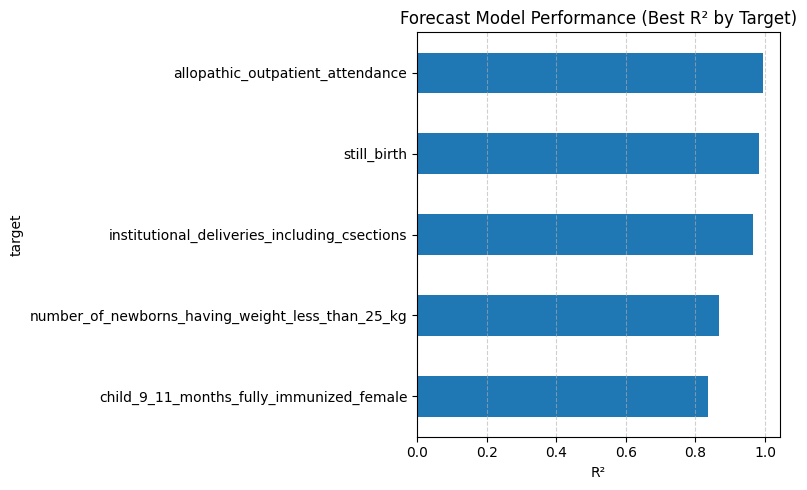

Visualization generated.

HMIS Forecasting + Quality Assessment pipeline complete.
->Forecast Summary: /Users/nanmr/WorkSpace/IISC_DataScienceAndBusinessAnalytics/DES_DA231o/Project/Delivery_Bundles/V1_Running_InProg/output_dir//hmis_forecast_summary
->Feature Importances: /Users/nanmr/WorkSpace/IISC_DataScienceAndBusinessAnalytics/DES_DA231o/Project/Delivery_Bundles/V1_Running_InProg/output_dir//hmis_feature_importance
->Anomaly Flags: /Users/nanmr/WorkSpace/IISC_DataScienceAndBusinessAnalytics/DES_DA231o/Project/Delivery_Bundles/V1_Running_InProg/output_dir//hmis_anomaly_flags


In [ ]:
ensure_df_session(ml_df, name='ml_df')
ensure_spark()

# ===================================================================================
# Next-Quarter Prediction (OOM-friendly version)
# Predict next quarter (label = next quarter's value).
# ===================================================================================


# --- Guard: ensure ml_df belongs to the ACTIVE SparkSession ---
def _same_session(df, spark):
    try:
        return df.sql_ctx.sparkSession._jsparkSession == spark._jsparkSession
    except Exception:
        return False

try:
    _ = spark.range(1).count()  # sanity check that session is alive
except Exception as _e:
    raise RuntimeError("SparkSession is not active. Run the High-memory Spark cell first.") from _e

if not _same_session(ml_df, spark):
    raise RuntimeError("`ml_df` was created under a different SparkSession. "
                       "Recreate or reload `ml_df` AFTER running the High-memory Spark cell, then retry.")

# ---------- Parameters ----------
HORIZON_QUARTERS = 1 # forecast horizon for next-quarter prediction (we create label = t+1)
LAGS = [1, 2, 3] # lags in quarters to create
ROLL_WINDOWS = [2, 3] # rolling window sizes (quarters)
MIN_HISTORY = 8 # minimum quarters of history per subdistrict to be considered

RESULTS_PATH = f"{OUTPUT_DIR}/hmis_spark_nextq_results"
IMPORTANCE_PATH = f"{OUTPUT_DIR}/hmis_feature_importances"
MODELS_DIR = f"{OUTPUT_DIR}/hmis_spark_models"

from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor, RandomForestRegressor, LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import StorageLevel
import math, os
import pandas as pd

# ensure directories exist (for local file system; Spark writes will create folders)
os.makedirs(RESULTS_PATH, exist_ok=True)
os.makedirs(IMPORTANCE_PATH, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# ---------- Build time_index for ordering quarters ----------
# Assumes year_quarter like 'YYYY-Q' (e.g., '2020-1'). Adjust parsing if different.
ml_df = ml_df.withColumn("year_int", F.split(F.col("year_quarter"), "-").getItem(0).cast("int")) \
             .withColumn("q_int",    F.split(F.col("year_quarter"), "-").getItem(1).cast("int")) \
             .withColumn("time_index", F.col("year_int") * 10 + F.col("q_int"))

# ---------- Filter subdistricts with enough history ----------
counts = ml_df.groupBy("state_name","district_name","subdistrict_name") \
              .agg(F.count(F.col("year_quarter")).alias("n_quarters")) \
              .filter(F.col("n_quarters") >= MIN_HISTORY)

valid_subd = counts.select("state_name","district_name","subdistrict_name")
ml_df = ml_df.join(valid_subd, on=["state_name","district_name","subdistrict_name"], how="inner")

print(f"Subdistricts with >={MIN_HISTORY} quarters retained; rows now: {ml_df.count():,}")

# ===================================================================================
# Create lag & rolling features using Spark window
# ===================================================================================

# ---------- Define window ----------
w = Window.partitionBy("state_name", "district_name", "subdistrict_name").orderBy("time_index")

# ---------- Optional: Restrict features to those actually used in the mapping ----------
used_features = set(sum(target_feature_map.values(), []))
value_cols = [c for c in numeric_cols if c in used_features and c in ml_df.columns]

print(f"Creating lag and rolling mean features for {len(value_cols)} columns...")

# ---------- Define lag and rolling settings ----------
LAGS = [1, 2, 3]
ROLL_WINDOWS = [2, 3]

# ---------- Build all lag expressions ----------
lag_exprs = [
    F.lag(F.col(c), lag).over(w).alias(f"{c}_lag{lag}")
    for c in value_cols
    for lag in LAGS
]

# ---------- Build all rolling mean expressions ----------
roll_exprs = [
    F.avg(F.col(c)).over(w.rowsBetween(-rw + 1, 0)).alias(f"{c}_ma{rw}")
    for c in value_cols
    for rw in ROLL_WINDOWS
]

# ---------- Apply all transformations at once ----------
ml_df = ml_df.select("*", *lag_exprs, *roll_exprs)

# ---------- Fill missing values for engineered features ----------
eng_feats = [f"{c}_lag{lag}" for c in value_cols for lag in LAGS] + \
             [f"{c}_ma{rw}" for c in value_cols for rw in ROLL_WINDOWS]

for ef in eng_feats:
    if ef in ml_df.columns:
        ml_df = ml_df.withColumn(ef, F.coalesce(F.col(ef), F.lit(0.0)))

# ---------- Cache engineered dataset ----------
ml_df = ml_df.persist(StorageLevel.MEMORY_AND_DISK)
print(f"Created lag and rolling mean features safely - {len(ml_df.columns)} columns, {ml_df.count():,} rows.")

# ---------- Create next-quarter label (t+1) using lead() ----------
label_w = Window.partitionBy("state_name","district_name","subdistrict_name").orderBy("time_index")
# For each target we'll create label column dynamically: label_<target> = lead(target,1)
# But for modeling loop, we will create one canonical column 'label' per target during selection.

# ---------- Determine global max time_index and split index for time-based train/test ----------
quantile = ml_df.approxQuantile("time_index", [0.8], 0.01)[0]
split_index = int(quantile)
print(f" Dynamic split_index at 80th percentile = {split_index}")

# ---------- Evaluation helpers (Spark-only) ----------
reg_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
reg_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

def compute_spark_metrics(pred_df):
    """
    Compute RMSE, MAE, MAPE, R2 using Spark aggregations.
    pred_df must contain 'label' and 'prediction'.
    """
    df = pred_df.select(
        F.col("label").cast("double"),
        F.col("prediction").cast("double")
    ).na.drop()

    n = df.count()
    if n == 0:
        return {
            "rmse": None,
            "mae": None,
            "mape": None,
            "r2": None,
            "n": 0,
        }

    # RMSE via evaluator
    try:
        rmse = reg_rmse.evaluate(df)
    except Exception:
        rmse = None

    # R2 via evaluator
    try:
        r2 = reg_r2.evaluate(df)
    except Exception:
        r2 = None

    # MAE & MAPE via Spark aggregations
    df2 = df.withColumn("err", F.col("prediction") - F.col("label")) \
            .withColumn("abs_err", F.abs(F.col("err"))) \
            .withColumn(
                "ape",
                F.when(F.col("label") != 0,
                       F.abs(F.col("err") / F.col("label"))).otherwise(None)
            )
    mae = df2.select(F.avg("abs_err")).collect()[0][0]
    ape_mean = df2.select(F.mean("ape")).collect()[0][0]
    mape = ape_mean * 100 if ape_mean is not None else None

    return {
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "r2": r2,
        "n": n,
    }

# ---------- ML loop: for each target, create t+1 label, filter, train and evaluate -----------
results = []          # (target, model, rmse, mae, mape, r2)
feat_importances = [] # rows: (target, model, feature, importance)
ts_frames = []        # list of pandas DataFrames with time-series preds

for target, feat_list in target_feature_map.items():
    print(f"\n Preparing target: {target}")
    if target not in ml_df.columns:
        print(f"target '{target}' not present in ml_df — skipping.")
        continue

    # Build label column (t+1) into a temp DataFrame
    df_label = ml_df.withColumn("label", F.lead(F.col(target), HORIZON_QUARTERS).over(label_w))
    # Filter rows where label is not null (we cannot train on last horizon)
    df_label = df_label.filter(F.col("label").isNotNull())

    # Select valid features from mapping (only those present)
    valid_feats = [f for f in feat_list if f in df_label.columns]
    if len(valid_feats) < 3:
        print(f"Only {len(valid_feats)} valid features for {target}; need >=3. Skipping.")
        continue

    # Expand assembled_inputs with engineered features: include original, lag1, ma(window=3) if present
    assembled_inputs = []
    for f in valid_feats:
        assembled_inputs.append(f)
        if f"{f}_lag1" in df_label.columns:
            assembled_inputs.append(f"{f}_lag1")
        if f"{f}_ma3" in df_label.columns:
            assembled_inputs.append(f"{f}_ma3")

    # De-duplicate preserving order
    seen = set()
    assembled_inputs = [x for x in assembled_inputs if not (x in seen or seen.add(x))]

    print(f"  Using {len(assembled_inputs)} features after adding engineered variants.")

    # base cols to carry through preds for TS/anomaly exports
    base_cols = ["state_name","district_name","subdistrict_name","year_quarter","time_index"]

    # Narrow to train/test using time_index split
    train_df = df_label.filter(F.col("time_index") <= split_index).select(*base_cols, *assembled_inputs, "label")
    test_df  = df_label.filter(F.col("time_index") >=  split_index).select(*base_cols, *assembled_inputs, "label")

    # Cast to double and fill nulls
    for c in assembled_inputs + ["label"]:
        train_df = train_df.withColumn(c, F.col(c).cast("double"))
        test_df  = test_df.withColumn(c, F.col(c).cast("double"))
    train_df = train_df.na.fill(0.0)
    test_df  = test_df.na.fill(0.0)

    train_count = train_df.count(); test_count = test_df.count()

    if test_count == 0:
        print(f"Skipping {target}: no test data available for split_index={split_index}.")
        continue
    elif train_count < 50 or test_count < 10:
        print(f"small train/test sample (train={train_count}, test={test_count}) — results may be unstable.")

    # Assemble and scale
    assembler = VectorAssembler(inputCols=assembled_inputs, outputCol="features", handleInvalid="keep")
    scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withMean=True, withStd=True)

    # ---------- Models with hyperparameters from 2nd code section ----------
    lr = LinearRegression(
        featuresCol="features_scaled",
        labelCol="label",
        maxIter=100
    )
    rf = RandomForestRegressor(
        featuresCol="features_scaled",
        labelCol="label",
        numTrees=100,
        maxDepth=10
    )
    gbt = GBTRegressor(
        featuresCol="features_scaled",
        labelCol="label",
        maxIter=100,
        maxDepth=8
    )

    # Pipelines: all models use assembler + scaler so they see features_scaled
    pipelines = {
        "LinearRegression": Pipeline(stages=[assembler, scaler, lr]),
        "RandomForest":     Pipeline(stages=[assembler, scaler, rf]),
        "GBT":              Pipeline(stages=[assembler, scaler, gbt]),
    }

    for mname, pipe in pipelines.items():
        try:
            model = pipe.fit(train_df)
            preds = model.transform(test_df).select(
                "state_name","district_name","subdistrict_name",
                "year_quarter","time_index","label","prediction"
            )

            metrics = compute_spark_metrics(preds)

            results.append((
                target,
                mname,
                float(metrics["rmse"]) if metrics["rmse"] is not None else None,
                float(metrics["mae"])  if metrics["mae"]  is not None else None,
                float(metrics["mape"]) if metrics["mape"] is not None else None,
                float(metrics["r2"])   if metrics["r2"]   is not None else None,
            ))

            print(
                f"    {mname} | "
                f"RMSE={metrics['rmse'] or 0:.3f} "
                f"MAE={metrics['mae'] or 0:.3f} "
                f"MAPE={(metrics['mape'] or 0):.2f}% "
                f"R2={(metrics['r2'] or 0):.3f}"
            )

            # collect time-series rows for dashboard export
            try:
                pdf_ts = preds.withColumn("label_raw", F.col("label")) \
                              .withColumn("pred_raw", F.col("prediction")) \
                              .select(
                                  "state_name","district_name","subdistrict_name",
                                  "year_quarter","time_index","label_raw","pred_raw"
                              ).toPandas()
                pdf_ts["target"] = target
                pdf_ts["model"] = mname
                ts_frames.append(pdf_ts)
            except Exception as e_ts:
                print(f"      Could not collect time-series for {target}, model {mname}: {e_ts}")

            # Extract feature importances for tree models
            if mname in ("RandomForest","GBT"):
                tree_model = model.stages[-1]
                fi = list(tree_model.featureImportances)
                # map back to feature names
                for feat, imp in zip(assembled_inputs, fi):
                    if imp and imp > 0:
                        feat_importances.append((target, mname, feat, float(imp)))

            # Optionally save model (commented out--uncomment if storage permitted)
            # save_path = f"{MODELS_DIR}/{target}/{mname}"
            # model.write().overwrite().save(save_path)

        except Exception as e:
            print(f"    {mname} failed for {target}: {e}")

# ---------- Save results & importances ----------
if results:
    results_df = spark.createDataFrame(
        results,
        ["target","model","rmse","mae","mape","r2"]
    )
    results_df.coalesce(1).write.mode("overwrite").option("header",True).csv(RESULTS_PATH)
    print(f"\nNext-quarter model results saved - {RESULTS_PATH}")
    results_df.show(truncate=False)
else:
    print("No model results produced.")

if feat_importances:
    fi_df = spark.createDataFrame(feat_importances, ["target","model","feature","importance"])
    fi_df.coalesce(1).write.mode("overwrite").option("header",True).csv(IMPORTANCE_PATH)
    print(f"Feature importances saved - {IMPORTANCE_PATH}")
    # show top 10 importances
    fi_df.orderBy(F.desc("importance")).show(20, truncate=False)
else:
    print("No feature importances recorded (tree models may have failed or returned zero importances).")

# ---------- Cleanup helper columns ----------
ml_df = ml_df.drop("year_int","q_int","time_index")
print("\nSpark-only next-quarter forecasting completed.")

# ============================================================
# Final Reporting, Feature Importance & Anomaly Detection
# ============================================================

from pyspark.sql import functions as F

summary_path = f"{OUTPUT_DIR}/hmis_forecast_summary"
flagged_path = f"{OUTPUT_DIR}/hmis_anomaly_flags"
fi_path = f"{OUTPUT_DIR}/hmis_feature_importance"

# ---------- Consolidated Forecast Summary ----------
if results:
    summary_df = spark.createDataFrame(
        results,
        ["target","model","rmse","mae","mape","r2"]
    )

    summary_df = summary_df.orderBy(F.desc("r2"))
    summary_df.show(truncate=False)

    summary_df.coalesce(1).write.mode("overwrite").option("header", True).csv(summary_path)
    print(f"\nForecast summary saved → {summary_path}")
else:
    print("No model results found to summarize.")

# ---------- Feature Importances Export ----------
if feat_importances:
    fi_df = spark.createDataFrame(feat_importances, ["target", "model", "feature", "importance"])
    fi_df = fi_df.orderBy(F.desc("importance"))
    fi_df.coalesce(1).write.mode("overwrite").option("header", True).csv(fi_path)
    print(f"Feature importances saved → {fi_path}")

    print("\nTop 15 Most Influential Features (across models):")
    fi_df.show(15, truncate=False)
else:
    print("No feature importances recorded (tree models may have returned zero importances).")

# ---------- Residual-Based Anomaly Detection ----------
#    (Simple version — highlights subdistrict–quarters with large errors)
try:
    # Use latest predictions available if `preds` variable exists in scope
    if "preds" in locals():
        anomaly_df = preds.withColumn("residual", F.col("prediction") - F.col("label"))
        stats = anomaly_df.select(
            F.mean("residual").alias("mean_res"),
            F.stddev("residual").alias("std_res")
        ).collect()[0]
        mean_res, std_res = stats["mean_res"], stats["std_res"]

        threshold = abs(std_res * 2)
        flagged = anomaly_df.filter(F.abs(F.col("residual") - mean_res) > threshold)
        count_anom = flagged.count()

        print(f"\n{count_anom:,} anomalous subdistrict–quarter predictions flagged (>|2σ|).")

        flagged.coalesce(1).write.mode("overwrite").option("header", True).csv(flagged_path)
        print(f"Anomaly records saved → {flagged_path}")
    else:
        print("No active predictions (`preds`) found; anomaly detection skipped.")
except Exception as e:
    print(f"Anomaly detection step skipped due to: {e}")

# ---------- Visualization ----------------------------------------------------
try:
    import matplotlib.pyplot as plt
    pdf = summary_df.toPandas()
    best_r2 = pdf.groupby("target")["r2"].max().sort_values(ascending=True)
    plt.figure(figsize=(8, 5))
    best_r2.plot.barh()
    plt.title("Forecast Model Performance (Best R² by Target)")
    plt.xlabel("R²")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    print("Visualization generated.")
except Exception as e:
    print(f"Visualization skipped ({e}).")

# ---------- Completion Message ------------------------------------------
print("\nHMIS Forecasting + Quality Assessment pipeline complete.")
print(f"->Forecast Summary: {summary_path}")
print(f"->Feature Importances: {fi_path}")
print(f"->Anomaly Flags: {flagged_path}")


In [7]:

# === Dashboard CSV Exports (metrics_v6, best_model_per_target_v6, forecast_timeseries) ===
import pandas as pd
import numpy as np

print("Exporting Dashboard CSVs...")

# Guard: ensure results exist
if not ('results' in globals() and results):
    print("No results list found; nothing to export.")
else:
    # =========================================================
    # 1) metrics_v6.csv  (with RMSE, RMSLE, MAE, MAPE, R2, Adjusted R2)
    # =========================================================
    df_metrics = spark.createDataFrame(
        results,
        ["target","model","rmse","mae","mape","r2"]
    )
    df_metrics_pd = df_metrics.toPandas()

    # ---- Optional: enrich with RMSLE & Adjusted R2 using ts_frames ----
    if 'ts_frames' in globals() and ts_frames:
        ts_all = pd.concat(ts_frames, ignore_index=True)

        # ensure needed cols
        needed_cols = {"target","model","label_raw","pred_raw"}
        missing = needed_cols - set(ts_all.columns.str.lower())
        # normalize lower
        ts_all.columns = [c.lower() for c in ts_all.columns]

        for (t, m), grp in ts_all.groupby(["target","model"]):
            y_true = grp["label_raw"].astype(float)
            y_pred = grp["pred_raw"].astype(float)

            # filter non-negative for RMSLE
            mask = (y_true >= 0) & (y_pred >= 0)
            y_true_nn = y_true[mask]
            y_pred_nn = y_pred[mask]
            if len(y_true_nn) > 0:
                rmsle_val = float(np.sqrt(np.mean((np.log1p(y_pred_nn) - np.log1p(y_true_nn))**2)))
            else:
                rmsle_val = np.nan

            # adjusted R^2
            # n = number of test samples for this target-model
            n = int(len(y_true))
            # p = number of features used for this target (same across models)
            p = None
            if 'feature_counts' in globals():
                p = feature_counts.get(t)
            if p is None:
                # fallback: safe default small p
                p = 5
            if n > p + 1 and not np.isnan(rmsle_val):
                # use existing R2 if present, else compute from y_true/y_pred
                row_idx = (df_metrics_pd["target"] == t) & (df_metrics_pd["model"] == m)
                if row_idx.any():
                    r2_val = df_metrics_pd.loc[row_idx, "r2"].iloc[0]
                else:
                    # compute simple R2
                    ss_res = float(np.sum((y_true - y_pred)**2))
                    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
                    r2_val = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
                if r2_val is not None and not pd.isna(r2_val):
                    adj_r2_val = 1 - ((1 - r2_val) * (n - 1)) / max(n - p - 1, 1)
                else:
                    adj_r2_val = np.nan
            else:
                adj_r2_val = np.nan

            # write back into metrics df
            row_mask = (df_metrics_pd["target"] == t) & (df_metrics_pd["model"] == m)
            df_metrics_pd.loc[row_mask, "rmsle"] = rmsle_val
            df_metrics_pd.loc[row_mask, "adjusted_r2"] = adj_r2_val

    else:
        # create empty columns for compatibility
        df_metrics_pd["rmsle"] = pd.NA
        df_metrics_pd["adjusted_r2"] = pd.NA

    # Save metrics_v6.csv
    df_metrics_pd.to_csv(f"{OUTPUT_DIR}/metrics_v6.csv", index=False)
    print("  metrics_v6.csv exported.")

    # =========================================================
    # 2) best_model_per_target_v6.csv
    # =========================================================
    sort_cols = ["target","rmse"]
    df_sorted = df_metrics_pd.sort_values(sort_cols, ascending=[True, True])
    best = df_sorted.groupby("target").head(1)
    best.to_csv(f"{OUTPUT_DIR}/best_model_per_target_v6.csv", index=False)
    print("  best_model_per_target_v6.csv exported.")

# =========================================================
# 3) forecast_timeseries.csv (actual + predicted, per target & model)
# =========================================================
if "ts_frames" in globals() and ts_frames:
    full_ts = pd.concat(ts_frames, ignore_index=True)
    full_ts = full_ts.sort_values(["target","model","time_index"])
    full_ts.to_csv(f"{OUTPUT_DIR}/forecast_timeseries.csv", index=False)
    print("  forecast_timeseries.csv exported.")
else:
    print("ts_frames not found or empty; forecast_timeseries.csv not written.")

print("Dashboard export completed.")


Exporting Dashboard CSVs...
  metrics_v6.csv exported.
  best_model_per_target_v6.csv exported.
  forecast_timeseries.csv exported.
Dashboard export completed.
